In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score


## Loading and Pre-processing

In [ ]:
original_df = pd.read_csv("/Users/Shashank/Downloads/Team project/SunCountry.csv", parse_dates=["PNRCreateDate", "ServiceStartDate", "EnrollDate"],
                 dtype={'ServiceStartCity':'string', 'ServiceEndCity':'string', 'PostalCode':'string', 'BookingChannel':'string',
                        'MarketingFlightNbr':'Int64', 'UFlyRewardsNumber':'Int64', 'UflyMemberStatus':'string'},
                 na_values={'MarketingFlightNbr':"OPEN"})
original_df.head()

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
0,AAABJK,3377365159634,2,JFK,MSP,2013-11-23,2013-12-13,BRUMSA,4252554D4241434B44696420493F7C2067657420746869...,F,...,234.20,0.0,<NA>,<NA>,NaN,CHEOPQ,NaT,244,SY,O
1,AAABJK,3377365159634,1,MSP,JFK,2013-11-23,2013-12-08,BRUMSA,4252554D4241434B44696420493F7C2067657420746869...,F,...,234.20,0.0,<NA>,<NA>,NaN,CHEOPQ,NaT,243,SY,NaN
2,AAABMK,3372107381942,2,MSP,SFO,2014-02-04,2014-02-23,EILDRY,45494C4445525344696420493F7C206765742074686973...,M,...,293.96,338.0,<NA>,<NA>,NaN,NaN,NaT,397,SY,O
3,AAABMK,3372107381942,1,SFO,MSP,2014-02-04,2014-02-20,EILDRY,45494C4445525344696420493F7C206765742074686973...,M,...,293.96,338.0,<NA>,<NA>,NaN,NaN,NaT,392,SY,NaN
4,AAABTP,3372107470782,1,MCO,MSP,2014-03-13,2014-04-23,SKELMA,534B454C544F4E44696420493F7C206765742074686973...,F,...,112.56,132.0,<NA>,<NA>,NaN,NaN,NaT,342,SY,NaN


In [ ]:
original_df = original_df.loc[original_df.MarketingAirlineCode == 'SY']

In [ ]:
df_ind = original_df.groupby('EncryptedName').agg({'GenderCode':'last', 'Age':'max', 'TicketNum':'count',
                                          'BkdClassOfService': lambda x: pd.Series.mode(x)[0],
                                          'BookingChannel': lambda x: pd.Series.mode(x)[0],
                                          'UflyMemberStatus': 'last',
                                          'BaseFareAmt': 'mean',
                                          'EnrollDate': 'last'}).reset_index()

In [ ]:
original_df.loc[original_df.UflyMemberStatus.isna(), 'UflyMemberStatus'] = 'Nonmember'


original_df.loc[original_df.StopoverCode.isna(), 'StopoverCode'] = 'N'


original_df.loc[original_df.BookedProduct.isna(), 'BookedProduct'] = 'N'

# Some BookingChannels are just airport names. So we'll replace it by 'Airport'
booking_channels = ['Outside Booking', 'SCA Website Booking', 'Reservations Booking', 'Tour Operator Portal', 'SY Vacation']
original_df['BookingChannel'] = original_df['BookingChannel'].apply(lambda x: x if x in booking_channels else 'Airport')

In [ ]:
original_df[(original_df['Age'] > 100) & (original_df['Age'] < 120)]['EncryptedName'].unique().shape

(841,)

841 people Aged between 100 to 120. Don't seem like outliers. Definitely plausible.

In [ ]:
# Impute the agefor the records to fall within the 0-120 interval
original_df['Age'] = original_df[(original_df['Age'] < 120) & (original_df['Age'] > 0)]['Age']

In [ ]:
original_df['month'] = original_df['ServiceStartDate'].dt.month
original_df['booking_month'] = original_df['PNRCreateDate'].dt.month

## Sanity checks and Analysis

In [ ]:
original_df.UflyMemberStatus.value_counts()

Nonmember    2735876
Standard      680113
Elite          14361
Name: UflyMemberStatus, dtype: Int64

In [ ]:
original_df[original_df['UflyMemberStatus'].isna() & original_df['UFlyRewardsNumber'].notnull()]

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode


In [ ]:
original_df[original_df['UflyMemberStatus'].isna() & original_df['EnrollDate'].notnull()]

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode


Q1) Are the elite members having more coupon sequence numbers?

<AxesSubplot: xlabel='CouponSeqNbr', ylabel='count'>

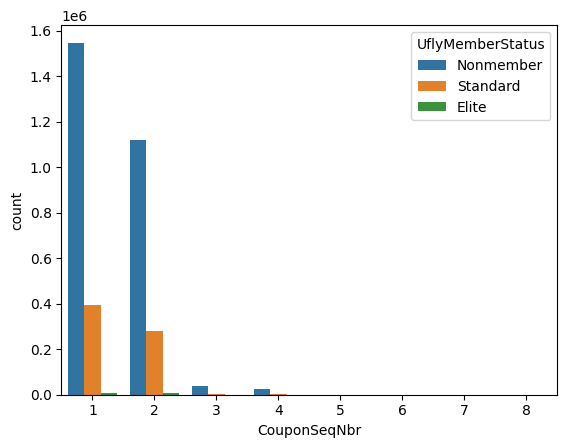

In [ ]:
sns.countplot(x='CouponSeqNbr', data=original_df, hue='UflyMemberStatus')

There seems to be no relation between coupon codes used and Member status. Most of them are used by Non-members, irrespective of the coupon code.

<AxesSubplot: xlabel='StopoverCode', ylabel='count'>

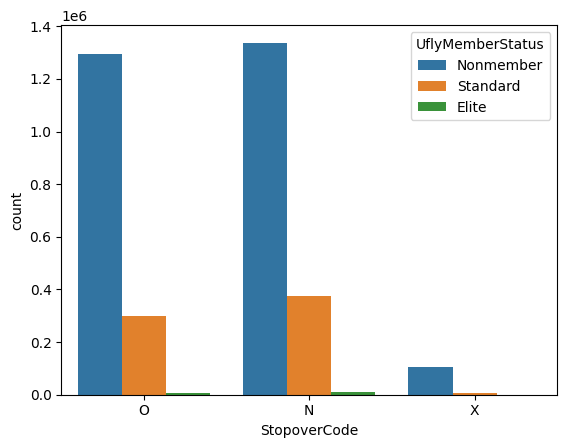

In [ ]:
sns.countplot(x='StopoverCode', data=original_df, hue='UflyMemberStatus')

Nothing obvious between member status and stop overs. Which makes sense.

<AxesSubplot: xlabel='BookingChannel', ylabel='count'>

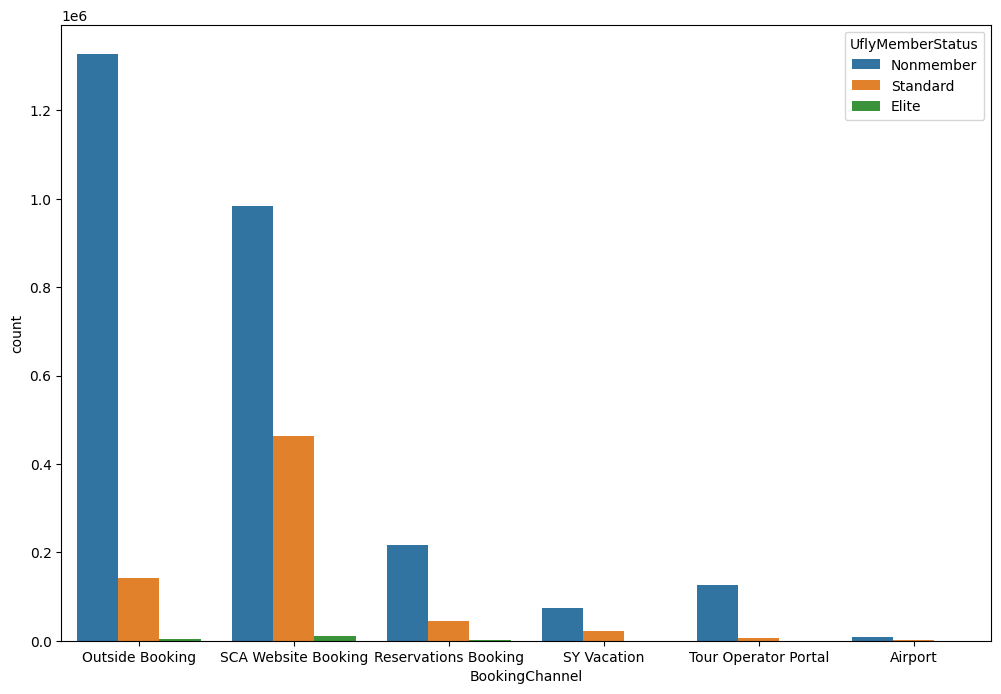

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=original_df, x='BookingChannel', hue='UflyMemberStatus')

In [ ]:
original_df.groupby('BookingChannel')['UflyMemberStatus'].value_counts()

BookingChannel        UflyMemberStatus
Airport               Nonmember              9097
                      Standard               2599
                      Elite                   219
Outside Booking       Nonmember           1327200
                      Standard             141038
                      Elite                  2941
Reservations Booking  Nonmember            215786
                      Standard              45672
                      Elite                   869
SCA Website Booking   Nonmember            984449
                      Standard             462405
                      Elite                 10273
SY Vacation           Nonmember             73431
                      Standard              21116
                      Elite                    54
Tour Operator Portal  Nonmember            125913
                      Standard               7283
                      Elite                     5
Name: UflyMemberStatus, dtype: int64

In [ ]:
original_df.groupby('BookingChannel')['UflyMemberStatus'].value_counts(normalize = True)

BookingChannel        UflyMemberStatus
Airport               Nonmember           0.763491
                      Standard            0.218128
                      Elite               0.018380
Outside Booking       Nonmember           0.902134
                      Standard            0.095867
                      Elite               0.001999
Reservations Booking  Nonmember           0.822584
                      Standard            0.174103
                      Elite               0.003313
SCA Website Booking   Nonmember           0.675610
                      Standard            0.317340
                      Elite               0.007050
SY Vacation           Nonmember           0.776218
                      Standard            0.223211
                      Elite               0.000571
Tour Operator Portal  Nonmember           0.945286
                      Standard            0.054677
                      Elite               0.000038
Name: UflyMemberStatus, dtype: float64

In [ ]:
original_df.UflyMemberStatus.value_counts()

Nonmember    2735876
Standard      680113
Elite          14361
Name: UflyMemberStatus, dtype: Int64

In [ ]:
original_df.groupby('UflyMemberStatus')['BookingChannel'].value_counts(normalize = True)

UflyMemberStatus  BookingChannel      
Elite             SCA Website Booking     0.715340
                  Outside Booking         0.204791
                  Reservations Booking    0.060511
                  Airport                 0.015250
                  SY Vacation             0.003760
                  Tour Operator Portal    0.000348
Nonmember         Outside Booking         0.485110
                  SCA Website Booking     0.359830
                  Reservations Booking    0.078873
                  Tour Operator Portal    0.046023
                  SY Vacation             0.026840
                  Airport                 0.003325
Standard          SCA Website Booking     0.679894
                  Outside Booking         0.207374
                  Reservations Booking    0.067154
                  SY Vacation             0.031048
                  Tour Operator Portal    0.010709
                  Airport                 0.003821
Name: BookingChannel, dtype: float64

In [ ]:
original_df.groupby('UflyMemberStatus')['BookingChannel'].value_counts()

UflyMemberStatus  BookingChannel      
Elite             SCA Website Booking       10273
                  Outside Booking            2941
                  Reservations Booking        869
                  Airport                     219
                  SY Vacation                  54
                  Tour Operator Portal          5
Nonmember         Outside Booking         1327200
                  SCA Website Booking      984449
                  Reservations Booking     215786
                  Tour Operator Portal     125913
                  SY Vacation               73431
                  Airport                    9097
Standard          SCA Website Booking      462405
                  Outside Booking          141038
                  Reservations Booking      45672
                  SY Vacation               21116
                  Tour Operator Portal       7283
                  Airport                    2599
Name: BookingChannel, dtype: int64

In [ ]:
(984449/2735876)*100

35.98295390580567

* 67 percent or 984449 customers who are booking via the SCA website are actually non-members. So although the non-members are visiting the SCA website, they choose to remain as non-members. Targeting these customers definitely would be a great first step.


* Now let's see what proportion of non-members are actually making their bookings via the SCA website. This is 35%. That means, 35% of all the non-members are actually making their bookings on the SCA website.



* If we understand how this group of 900,000 non-members operate, finding out interesting insights like:   
    1) What are the popular airports they tend to travel to / from. i.e. Service start and End Cities.  
    2) How many of them flying First Class or Discounted First Class?  
    3) How many are Male or Female?  
    4) Average Base Fare amount or Highest Base Fare Amount? Compare that to the average base fare amount of the Elite        and say, see, these people are actually paying equal or more than the elite customers, so why don't we target          these specific customers and offer them lucrative promotions first to drive enrollment.  
    5) Any specific Age group trends?

## EDA Recommendations

In [ ]:
priority_non_members = original_df[(original_df['BookingChannel'] == "SCA Website Booking") & (original_df['UflyMemberStatus'] == "Nonmember")] 

In [ ]:
priority_non_members

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
2,AAABMK,3372107381942,2,MSP,SFO,2014-02-04,2014-02-23,EILDRY,45494C4445525344696420493F7C206765742074686973...,M,...,293.96,338.0,<NA>,Nonmember,NaN,N,NaT,397,SY,O
3,AAABMK,3372107381942,1,SFO,MSP,2014-02-04,2014-02-20,EILDRY,45494C4445525344696420493F7C206765742074686973...,M,...,293.96,338.0,<NA>,Nonmember,NaN,N,NaT,392,SY,N
5,AAACLY,3372106417509,1,PSP,MSP,2012-10-06,2013-02-12,HINZRI,48494E5A4544696420493F7C2067657420746869732072...,M,...,171.16,194.8,<NA>,Nonmember,NaN,N,NaT,610,SY,N
6,AAACWU,3372107969827,1,JFK,MSP,2014-10-21,2014-11-14,GIBAJU,47494241534A4F4E455344696420493F7C206765742074...,F,...,164.65,191.1,<NA>,Nonmember,NaN,SSWMIR,NaT,244,SY,N
7,AAACWU,3372107969828,1,JFK,MSP,2014-10-21,2014-11-14,GIBAAL,474942415344696420493F7C2067657420746869732072...,M,...,164.65,191.1,<NA>,Nonmember,NaN,SSWMIR,NaT,244,SY,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435280,ZZYNSZ,3372106641883,2,LAS,MSP,2013-02-04,2013-02-21,WEYEJO,574559455244696420493F7C2067657420746869732072...,F,...,313.49,358.8,<NA>,Nonmember,NaN,N,NaT,148,SY,O
3435334,ZZZDRL,3372107047358,1,JFK,MSP,2013-09-10,2013-09-11,VOLKYA,564F4C4B4F564144696420493F7C206765742074686973...,F,...,239.07,278.8,<NA>,Nonmember,NaN,N,NaT,244,SY,N
3435335,ZZZDRL,3372107047358,2,MSP,SFO,2013-09-10,2013-09-11,VOLKYA,564F4C4B4F564144696420493F7C206765742074686973...,F,...,239.07,278.8,<NA>,Nonmember,NaN,N,NaT,395,SY,X
3435378,ZZZZVS,3372107000214,2,SFO,MSP,2013-08-19,2013-09-20,DUNNKI,44554E4E44696420493F7C206765742074686973207269...,F,...,293.96,337.8,<NA>,Nonmember,NaN,N,NaT,396,SY,O


In [ ]:
priority_non_members = priority_non_members.drop(columns=['UFlyRewardsNumber', 'CardHolder', 'EnrollDate', 'PostalCode', 'birthdateid', 'CouponSeqNbr','MarketingAirlineCode', 'BookedProduct', 'StopoverCode'])


In [ ]:
# # Handle the missing values of Gender with mode
priority_non_members['GenderCode'] = priority_non_members['GenderCode'].fillna(priority_non_members['GenderCode'].mode()[0])

In [ ]:
# priority_non_members['Age'] = priority_non_members['Age'].fillna(priority_non_members['Age'].mean())
priority_non_members['Age']=priority_non_members['Age'].fillna(priority_non_members['Age'].mean())


In [ ]:
priority_non_members = priority_non_members.dropna()

In [ ]:
priority_non_members.isna().sum()

PNRLocatorID            0
TicketNum               0
CouponSeqNbr            0
ServiceStartCity        0
ServiceEndCity          0
PNRCreateDate           0
ServiceStartDate        0
PaxName                 0
EncryptedName           0
GenderCode              0
Age                     0
BkdClassOfService       0
TrvldClassOfService     0
BookingChannel          0
BaseFareAmt             0
TotalDocAmt             0
UflyMemberStatus        0
BookedProduct           0
MarketingFlightNbr      0
MarketingAirlineCode    0
StopoverCode            0
dtype: int64

In [ ]:
priority_non_members.shape

(984448, 21)

Okay, cleaning done. Let's see what we can derive from these records.

In [ ]:
priority_non_members.BaseFareAmt.describe()

count    984448.000000
mean        300.056895
std         163.440472
min           0.000000
25%         188.840000
50%         275.340000
75%         366.520000
max        1753.000000
Name: BaseFareAmt, dtype: float64

Let's compare the average and highest Base Fare amounts to the amounts that the Standard & Elite passengers paid

In [ ]:
# This is the mean of Elite fliers
original_df[(original_df['UflyMemberStatus'] == "Elite")].BaseFareAmt.mean()

409.09603648770974

In [ ]:
# This is the mean of Standard fliers
original_df[(original_df['UflyMemberStatus'] == "Standard")].BaseFareAmt.mean()

299.4465444418795

In [ ]:
# This is the mean of Standard and Elite fliers and Standard Fliers
original_df[(original_df['UflyMemberStatus'] == "Elite") | (original_df['UflyMemberStatus'] == "Standard")].BaseFareAmt.mean()

301.7139818913306

We can clearly see that, the mean base fare being paid by these 984448 non member potential targets is more than the fare that the Standard members are paying.

The respective fares are 300 and 299. This provides a strong case to target these 984448 non members by providing lucrative deals and convert them into members

In [ ]:
priority_non_members.EncryptedName.nunique()

491221

In [ ]:
priority_non_members['month'] = priority_non_members['ServiceStartDate'].dt.month
priority_non_members['booking_month'] = priority_non_members['PNRCreateDate'].dt.month

In [ ]:
priority_non_members.month.value_counts()

12    109059
3     108289
7      96082
8      89670
2      81838
6      80428
10     73997
4      73926
11     70634
1      70500
5      69340
9      60685
Name: month, dtype: int64

In [ ]:
# sns.lineplot(x='month', y='BaseFareAmt', data=priority_non_members)
monthly_non_members_fare_avgs = priority_non_members.groupby(['month']).count()['BaseFareAmt'].reset_index()

[Text(0.5, 1.0, 'Month wise counts of target non-members')]

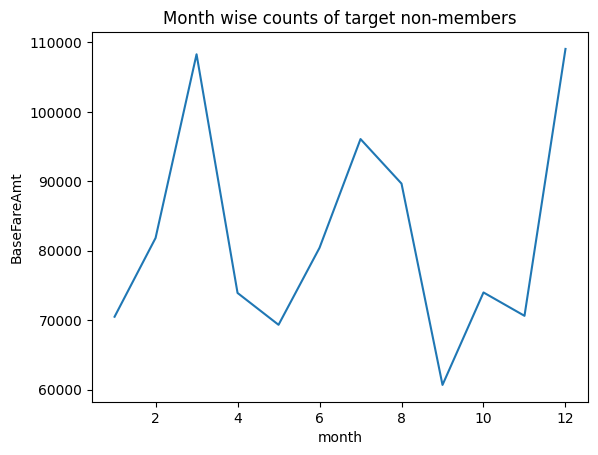

In [ ]:
sns.lineplot(x='month', y='BaseFareAmt', data=monthly_non_members_fare_avgs).set(
    title="Month wise counts of target non-members")

Majority of these 984448 non-members are actually travelling during the months of December(Festive Period?), March and July. 

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] >300)].shape

(404461, 18)

There are 491221 unqiue fliers out of 984448 non-members

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)]

,PNRLocatorID,TicketNum,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,Age,BkdClassOfService,TrvldClassOfService,BookingChannel,BaseFareAmt,TotalDocAmt,UflyMemberStatus,MarketingFlightNbr,month,booking_month
40,AABBUZ,3372106628348,MSP,PHX,2013-01-28,2013-01-28,GALLJE,47414C4C4F57415944696420493F7C2067657420746869...,F,28.0,Coach,Coach,SCA Website Booking,437.21,480.9,Nonmember,603,1,1
77,AABNZL,3372107124019,MSP,SEA,2013-10-14,2013-12-29,SANDSU,53414E44455244696420493F7C20676574207468697320...,F,55.0,Coach,Coach,SCA Website Booking,522.79,583.8,Nonmember,283,12,10
78,AABNZL,3372107124019,SEA,MSP,2013-10-14,2013-12-22,SANDSU,53414E44455244696420493F7C20676574207468697320...,F,55.0,Coach,Coach,SCA Website Booking,522.79,583.8,Nonmember,284,12,10
105,AACBGS,3372107702282,ANC,MSP,2014-06-27,2014-07-24,MCCAME,4D4343414D424C5944696420493F7C2067657420746869...,F,25.0,Coach,Coach,SCA Website Booking,783.11,844.9,Nonmember,472,7,6
106,AACBGS,3372107702282,MSP,ANC,2014-06-27,2014-08-06,MCCAME,4D4343414D424C5944696420493F7C2067657420746869...,F,25.0,Coach,Coach,SCA Website Booking,783.11,844.9,Nonmember,471,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435268,ZZYKXU,3372107679743,MSP,MCO,2014-06-18,2014-10-12,TALMDE,54414C4D41474544696420493F7C206765742074686973...,F,43.0,Coach,Coach,SCA Website Booking,463.25,520.0,Nonmember,341,10,6
3435269,ZZYKXU,3372107679744,MSP,MCO,2014-06-18,2014-10-12,TALMAN,54414C4D41474544696420493F7C206765742074686973...,F,7.0,Coach,Coach,SCA Website Booking,463.25,520.0,Nonmember,341,10,6
3435270,ZZYKXU,3372107679744,MCO,MSP,2014-06-18,2014-10-18,TALMAN,54414C4D41474544696420493F7C206765742074686973...,F,7.0,Coach,Coach,SCA Website Booking,463.25,520.0,Nonmember,340,10,6
3435271,ZZYKXU,3372107679742,MSP,MCO,2014-06-18,2014-10-12,TALMWI,54414C4D41474544696420493F7C206765742074686973...,M,49.0,Coach,Coach,SCA Website Booking,463.25,520.0,Nonmember,341,10,6


In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].EncryptedName.nunique()

86897

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].EncryptedName.nunique()

1155

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].describe()

,TicketNum,Age,BaseFareAmt,TotalDocAmt,MarketingFlightNbr,month,booking_month
count,1.811050e+05,181105.000000,181105.000000,181105.000000,181105.000000,181105.000000,181105.000000
mean,3.372107e+12,41.152536,563.678708,633.680574,424.858905,5.890804,6.462455
std,4.700300e+05,19.266334,160.176593,175.619313,158.660126,3.384348,3.389557
min,3.372106e+12,1.000000,409.120000,0.000000,100.000000,1.000000,1.000000
25%,3.372107e+12,27.000000,448.000000,511.600000,284.000000,3.000000,4.000000
50%,3.372107e+12,43.000000,518.130000,597.200000,396.000000,6.000000,6.000000
75%,3.372108e+12,56.000000,626.860000,701.800000,532.000000,8.000000,9.000000
max,3.372108e+12,111.000000,1753.000000,1885.500000,954.000000,12.000000,12.000000


In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].describe()

,TicketNum,CouponSeqNbr,birthdateid,Age,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,MarketingFlightNbr
count,1.436100e+04,14361.000000,14312.000000,14297.000000,14361.000000,14361.000000,1.436100e+04,14361.000000
mean,3.373118e+12,1.392173,41415.751328,49.901658,409.096036,458.559515,2.005119e+08,348.845902
std,2.071617e+09,0.504801,4556.518089,12.333972,262.658481,283.256267,1.810362e+07,136.782055
min,3.372106e+12,1.000000,18139.000000,1.000000,0.000000,0.000000,1.000030e+08,100.000000
25%,3.372107e+12,1.000000,38504.000000,42.000000,226.970000,263.800000,2.002909e+08,249.000000
50%,3.372108e+12,1.000000,41075.000000,51.000000,349.770000,395.200000,2.025366e+08,381.000000
75%,3.372108e+12,2.000000,44290.000000,58.000000,573.900000,635.200000,2.033998e+08,421.000000
max,3.377555e+12,6.000000,59665.000000,114.000000,1835.940000,2006.340000,2.410649e+08,954.000000


In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 400)].BkdClassOfService.value_counts()

Coach                   168166
First Class              25174
Discount First Class        51
Name: BkdClassOfService, dtype: int64

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].GenderCode.value_counts()

F    90754
M    90345
U        6
Name: GenderCode, dtype: int64

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].ServiceStartCity.value_counts().head()

MSP    87145
CUN    10435
SFO     8347
JFK     7009
RSW     5967
Name: ServiceStartCity, dtype: Int64

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].ServiceEndCity.value_counts().head()

MSP    86484
CUN    10452
SFO     8256
JFK     6889
RSW     6041
Name: ServiceEndCity, dtype: Int64

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].month.value_counts()

3     33681
7     23622
8     19075
2     17858
12    17725
6     16665
1     13390
4     12039
11     8105
10     7417
5      7293
9      4235
Name: month, dtype: int64

In [ ]:
priority_non_members[(priority_non_members['BaseFareAmt'] > 409)].booking_month.value_counts()

6     19943
1     18335
7     18201
5     17779
10    17438
11    14818
9     13752
2     13421
8     12837
12    12262
4     11303
3     11016
Name: booking_month, dtype: int64

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].BkdClassOfService.value_counts()

Coach                   10587
First Class              3742
Discount First Class       32
Name: BkdClassOfService, dtype: int64

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].Age.describe()

count    14297.000000
mean        49.901658
std         12.333972
min          1.000000
25%         42.000000
50%         51.000000
75%         58.000000
max        114.000000
Name: Age, dtype: float64

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].ServiceStartCity.value_counts().head()

MSP    6891
SFO     959
JFK     877
RSW     683
DCA     666
Name: ServiceStartCity, dtype: Int64

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].ServiceEndCity.value_counts().head()

MSP    6797
JFK     925
SFO     891
DCA     713
LAN     683
Name: ServiceEndCity, dtype: Int64

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].month.value_counts()

10    1476
11    1368
12    1314
9     1299
3     1195
4     1166
5     1153
2     1123
8     1113
7     1079
6     1042
1     1033
Name: month, dtype: int64

In [ ]:
original_df[(original_df['UflyMemberStatus'] == "Elite")].booking_month.value_counts()

10    1628
9     1462
8     1444
7     1372
11    1299
6     1214
4     1085
5     1067
1     1014
3      967
12     948
2      861
Name: booking_month, dtype: int64

The insight from this analysis:
There are 181105 non-members, with a mean age of around 41, are making their bookings via the SCA website, and are paying equal to or greater than the mean Elite Member Base Fare of 409. This group of customers should be the first to target, as they are already on the website, paying heavy fares. 

Do we know anythong more about these customers? 
0) The mean Age is 41
1) They travel most frequently primarily between MSP, CUN, SFO and JFK airports.  
2) Genders are equally distributed, so there is a balanced mix of males and females  
3) Around 25,000 of these fly first class too. So they can be given a free class upgrade next time and try to convert them into members.  
4) These 181105 primarily seem to travel in the months of March and July, and December seems popular too.  
5) These 181105 primarily book their tickets in the months of May- June-July.  



## In-depth niche analysis: Not using for Slides

<AxesSubplot: xlabel='BookingChannel', ylabel='Age'>

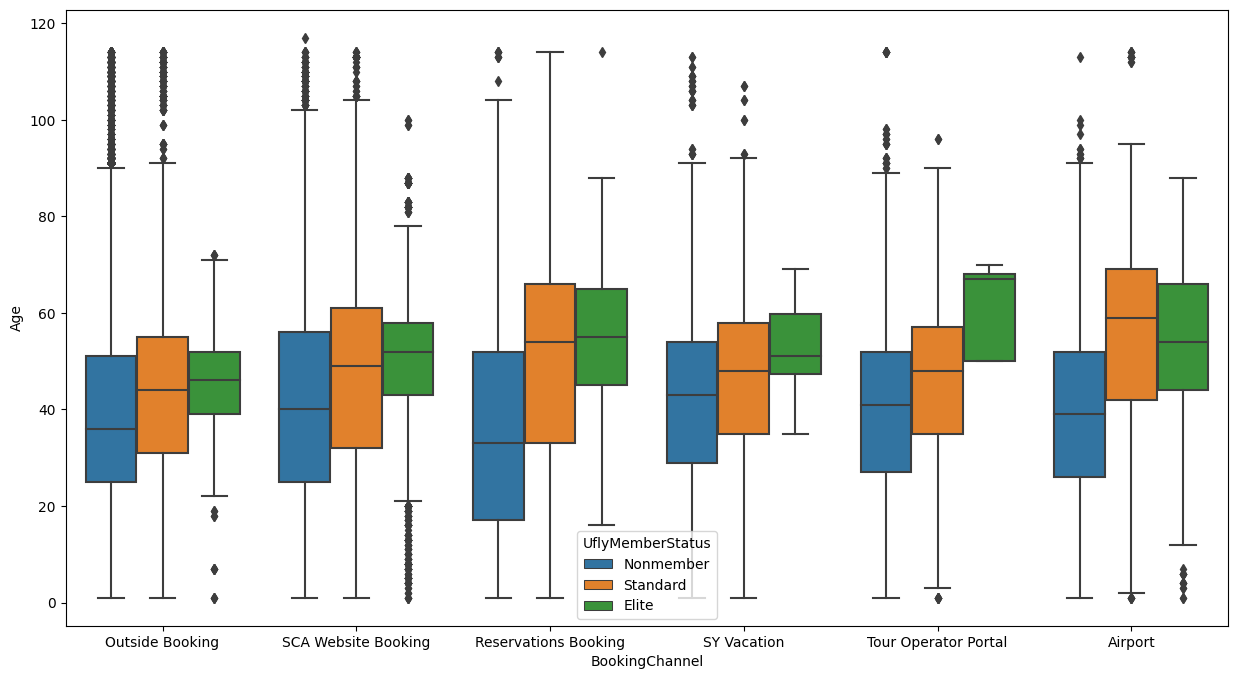

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=original_df, x='BookingChannel', y='Age', hue='UflyMemberStatus')

Members seem more likely to book from SCA website rather than outside booking. This feature could be useful.

In [ ]:
original_df[(original_df['BaseFareAmt'] > 2000) & (original_df['BaseFareAmt'] < 3000)]

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
99371,ATVGHC,3372107753993,1,CUN,MSP,2014-05-28,2014-08-31,NGUYLA,4E475559454E44696420493F7C20676574207468697320...,M,...,2664.0,279.99,<NA>,Nonmember,NaN,GRP,NaT,588,SY,N
99372,ATVGHC,3372107753993,1,CUN,MSP,2014-05-28,2014-08-31,NGUYLA,4E475559454E44696420493F7C20676574207468697320...,M,...,2664.0,279.99,<NA>,Nonmember,NaN,GRP,NaT,588,SY,N
99373,ATVGHC,3372107753993,1,CUN,MSP,2014-05-28,2014-08-31,NGUYLA,4E475559454E44696420493F7C20676574207468697320...,M,...,2664.0,279.99,<NA>,Nonmember,NaN,GRP,NaT,588,SY,N
99374,ATVGHC,3372107753994,1,CUN,MSP,2014-05-28,2014-08-31,NGUYAN,4E475559454E44696420493F7C20676574207468697320...,M,...,2664.0,279.99,<NA>,Nonmember,NaN,GRP,NaT,588,SY,N
99375,ATVGHC,3372107753994,1,CUN,MSP,2014-05-28,2014-08-31,NGUYAN,4E475559454E44696420493F7C20676574207468697320...,M,...,2664.0,279.99,<NA>,Nonmember,NaN,GRP,NaT,588,SY,N
99376,ATVGHC,3372107753994,1,CUN,MSP,2014-05-28,2014-08-31,NGUYAN,4E475559454E44696420493F7C20676574207468697320...,M,...,2664.0,279.99,<NA>,Nonmember,NaN,GRP,NaT,588,SY,N


1: BaseFareAmt > 4000: 149 records. All belong to the same flight, and all of the seem like an outlier  
2: BaseFareAmt > 3000 & BaseFareAmt < 4000 has one record, seems like a transferred ticket (TotalDocAmt = 0)  
3: BaseFareAmt > 2000 & BaseFareAmt < 3000 has 6 records. All booked by one person. Probably got a discount (TotalDocAmt = 279)  

>So an entire flight's info could be an outlier

What are the Booked Products across the dataset

In [ ]:
original_df['BookedProduct'].value_counts()[:10]

N         2204898
SSWMIR     390845
BSGTIX     137082
GRP        129515
EXP         99621
UP          78106
SCV         71888
SSWM        32137
FUNJET      25281
ORB         23536
Name: BookedProduct, dtype: int64

Which of the Booked Products are more associated with discounts?

In [ ]:
original_df[original_df['TotalDocAmt'] < original_df['BaseFareAmt']]['BookedProduct'].value_counts()[:10]

FUNJET     23997
ORB        23257
N          22809
TVLCTY     21224
DSNY       11191
APPLE       7927
STUNIV      5872
CHEOPQ      4250
PCLNOPQ     4181
EXP         3661
Name: BookedProduct, dtype: int64

<AxesSubplot: ylabel='count'>

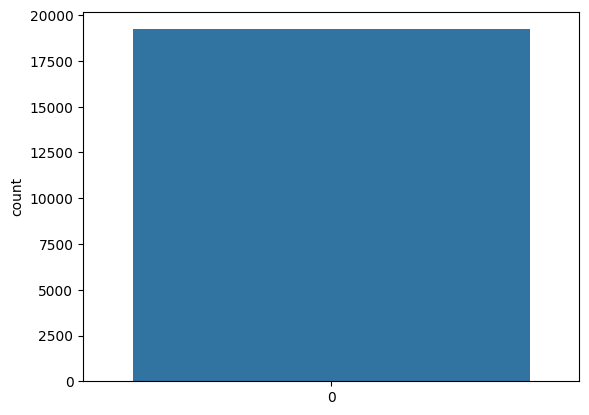

In [ ]:
sns.countplot(original_df[original_df['Age'] > 80]['EncryptedName'].value_counts())

19231 unique travellers above the Age 80. More even valued bookings than odd.
#### Older travellers prefer round-trips.

In [ ]:
original_df[original_df['BookedProduct'] == 'NAVY']

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
76066,ARWIZC,3372106774135,1,MSP,PNS,2013-04-18,2013-05-18,TOMPMI,544F4D504F5344696420493F7C20676574207468697320...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8850,SY,N
76067,ARWIZC,3372106774135,2,PNS,MSP,2013-04-18,2013-05-18,TOMPMI,544F4D504F5344696420493F7C20676574207468697320...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8851,SY,O
220644,BPNEVQ,3372106813856,2,PNS,MSP,2013-05-12,2013-05-18,UTTELA,555454455244696420493F7C2067657420746869732072...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8851,SY,O
220645,BPNEVQ,3372106813856,1,MSP,PNS,2013-05-12,2013-05-18,UTTELA,555454455244696420493F7C2067657420746869732072...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8850,SY,N
232129,BSLASB,3372106775434,2,PNS,MSP,2013-04-19,2013-05-18,KOELRO,4B4F454C424C44696420493F7C20676574207468697320...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8851,SY,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3405356,ZEYXEW,3372106759970,2,PNS,MSP,2013-04-09,2013-05-18,DEREDA,444552454D455244696420493F7C206765742074686973...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8851,SY,O
3405357,ZEYXEW,3372106759971,1,MSP,PNS,2013-04-09,2013-05-18,WATKMI,5741544B494E5344696420493F7C206765742074686973...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8850,SY,N
3405358,ZEYXEW,3372106759971,2,PNS,MSP,2013-04-09,2013-05-18,WATKMI,5741544B494E5344696420493F7C206765742074686973...,M,...,298.78,342.98,<NA>,Nonmember,NaN,NAVY,NaT,8851,SY,O
3405791,ZFGVZM,3372106751223,1,MSP,PNS,2013-04-04,2013-05-18,MEULAL,4D45554C4944696420493F7C2067657420746869732072...,M,...,329.30,375.80,<NA>,Nonmember,NaN,NAVY,NaT,8850,SY,N


Navy: Only two flights; Between MSP and PNS (From one to the other); One Non-stop, one has a hop. Only the first passenger paid slightly extra. 

Can give NAVY Code to that particular journey Itenerary, as promoting this to such a location lile PNS() which has a coast can help drive the sales for this particular flight / or these kind of flights in the future!

In [ ]:
original_df[original_df['MarketingFlightNbr'].isnull()]

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
456886,ECUDIT,3372107789222,2,JFK,MSP,2014-07-22,2014-08-10,OHAL,4F4844696420493F7C2067657420746869732072696768...,M,...,632.56,708.2,<NA>,Nonmember,NaN,N,NaT,<NA>,SY,O
2805211,FTMGDD,3372107273942,2,MSP,RSW,2013-12-05,2014-01-01,GREECI,475245454E44696420493F7C2067657420746869732072...,F,...,165.58,199.8,201961852,Standard,False,N,2009-01-01 21:57:32,<NA>,SY,O


In [ ]:
missing_flight = original_df[(original_df['ServiceStartDate'] == '2014-07-22') & (original_df['ServiceStartCity'] == 'JFK') & (original_df['ServiceEndCity'] == 'MSP')]
missing_flight

,PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
721,AAFCDN,3377452563100,1,JFK,MSP,2014-05-15,2014-07-22,KRUKTO,4B52554B4544696420493F7C2067657420746869732072...,M,...,183.25,208.0,<NA>,Nonmember,NaN,N,NaT,244,SY,N
722,AAFCDN,3377452563101,1,JFK,MSP,2014-05-15,2014-07-22,KRUKAS,4B52554B4544696420493F7C2067657420746869732072...,F,...,183.25,208.0,<NA>,Nonmember,NaN,N,NaT,244,SY,N
14065,ACMJWH,3377463344128,1,JFK,MSP,2014-07-03,2014-07-22,ROETE,524F4544696420493F7C20676574207468697320726967...,M,...,499.54,559.0,<NA>,Nonmember,NaN,N,NaT,248,SY,N
48997,AMABLC,3377420531145,1,JFK,MSP,2014-06-18,2014-07-22,CHANSU,4348414E44524153454B48415244696420493F7C206765...,M,...,165.16,0.0,<NA>,Nonmember,NaN,PCLN,NaT,244,SY,N
134043,BBMLWU,3377434268879,1,JFK,MSP,2014-06-05,2014-07-22,QUAROL,515541524245524744696420493F7C2067657420746869...,F,...,197.21,223.0,<NA>,Nonmember,NaN,N,NaT,244,SY,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353738,XOTKYU,3377457363361,1,JFK,MSP,2014-06-05,2014-07-22,ASSAVA,4153534144696420493F7C206765742074686973207269...,F,...,403.72,456.0,<NA>,Nonmember,NaN,N,NaT,244,SY,N
3353741,XOTKYU,3377457363362,1,JFK,MSP,2014-06-05,2014-07-22,CALAJA,43414C41425245534544696420493F7C20676574207468...,M,...,403.72,456.0,<NA>,Nonmember,NaN,N,NaT,244,SY,N
3378426,YKXCJG,3372107649385,2,JFK,MSP,2014-06-05,2014-07-22,RICHOL,5249434841524444696420493F7C206765742074686973...,F,...,394.42,446.0,210834702,Standard,False,SSWMIR,2014-04-01 11:25:42,244,SY,O
3378427,YKXCJG,3372107649386,2,JFK,MSP,2014-06-05,2014-07-22,FERGER,4645524755534F4E44696420493F7C2067657420746869...,F,...,394.42,446.0,210834702,Standard,False,SSWMIR,2014-04-01 11:25:42,244,SY,O


Remember the goals of the project:
Any analysis / questions / ML probem should revolve around obtaining a substanital answer to atleast one of these questions.
1) Do online booking channels meet the expectations?   

The answer to this question is going to be as vague as the question itself. What are the expectations? We know how the distribution of customers is across each platform and how are members interested in booking flights compared to non members. So is that it? good question.  

2) How do we drive enrollment of ufly reward?  Major Question. Possible ML usage?   
We have to understand how the members have any trends, what can we reccommend to the company. So is the answer via clustering( analysis on a paltry 0.5% data or ML( possible all of the data?). Good question.  

3) Does Sun country need to continue to develop products - vacation packages?  

4) Understand your customers more, it's all about what suggestions you can make to the higher ups to drive enrollment / increase sales / get more money in!




In [ ]:
original_df.ServiceStartCity.unique()

<StringArray>
['JFK', 'MSP', 'SFO', 'MCO', 'PSP', 'RSW', 'LAX', 'SEA', 'BOS', 'MDW', 'LAS',
 'PUJ', 'DFW', 'CUN', 'ANC', 'TPA', 'LAN', 'SXM', 'CZM', 'PHX', 'MIA', 'HRL',
 'DCA', 'SAN', 'SJU', 'LIR', 'IFP', 'ZIH', 'MZT', 'MBJ', 'PVR', 'SJD', 'STT',
 'HUX', 'GRB', 'GTF', 'PNS', 'FNL', 'SAT', 'MLI', 'LWS', 'RST', 'SJT', 'FSD',
 'DLH', 'GEG', 'FAR', 'PIE', 'YKM', 'RFD', 'FNT', 'GPT', 'GFK', 'ELP']
Length: 54, dtype: string

In [ ]:
target_airports = ['DFW', 'LAN','MSP']
freq_airports_df = original_df[(original_df['ServiceStartCity'].isin(target_airports)) & (original_df['ServiceEndCity'].isin(target_airports))]
freq_airports_df['month'] = freq_airports_df['ServiceStartDate'].dt.month
monthly_reward_cnts = freq_airports_df.groupby(['UflyMemberStatus','month']).count()['EncryptedName'].reset_index()
monthly_reward_cnts


/var/folders/64/fsh_bnwx7jd1dd9pm23hv7l00000gp/T/ipykernel_55248/3769528549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_airports_df['month'] = freq_airports_df['ServiceStartDate'].dt.month


,UflyMemberStatus,month,EncryptedName
0,Elite,1,92
1,Elite,2,92
2,Elite,3,118
3,Elite,4,134
4,Elite,5,133
5,Elite,6,143
6,Elite,7,133
7,Elite,8,115
8,Elite,9,125
9,Elite,10,141


<AxesSubplot: xlabel='month', ylabel='EncryptedName'>

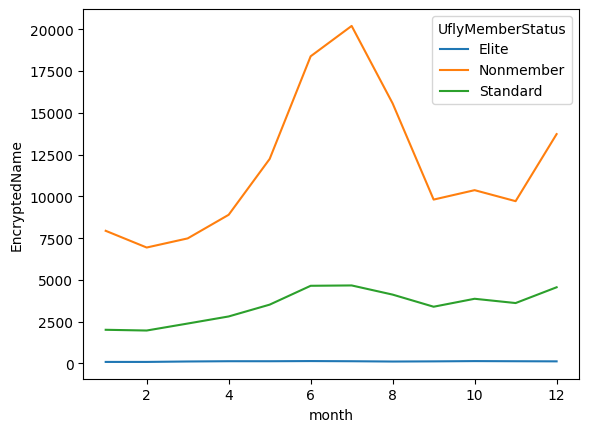

In [ ]:
sns.lineplot(x='month', y='EncryptedName', hue='UflyMemberStatus', data=monthly_reward_cnts)

In [ ]:
# freq_airports_df['avg_fare'] = freq_airports_df['BaseFareAmt'] - freq_airports_df['TotalDocAmt']
# rewards_df = freq_airports_df[freq_airports_df['rewards'] > 0]
# rewards_df['value_per_penny'] = 100 * rewards_df['rewards'] / rewards_df['BaseFareAmt']
monthly_fare_avgs = freq_airports_df.groupby(['UflyMemberStatus','month']).median()['BaseFareAmt'].reset_index()
monthly_fare_avgs


/var/folders/64/fsh_bnwx7jd1dd9pm23hv7l00000gp/T/ipykernel_55248/2325135058.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_fare_avgs = freq_airports_df.groupby(['UflyMemberStatus','month']).median()['BaseFareAmt'].reset_index()


,UflyMemberStatus,month,BaseFareAmt
0,Elite,1,180.46
1,Elite,2,202.80
2,Elite,3,231.28
3,Elite,4,200.94
4,Elite,5,219.54
5,Elite,6,226.97
6,Elite,7,280.92
7,Elite,8,220.46
8,Elite,9,180.46
9,Elite,10,180.46


<AxesSubplot: xlabel='month', ylabel='BaseFareAmt'>

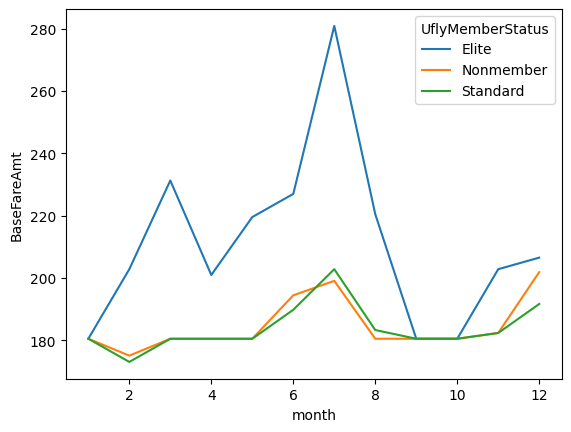

In [ ]:
sns.lineplot(x='month', y='BaseFareAmt', hue='UflyMemberStatus', data=monthly_fare_avgs)